In [68]:
import sys, os, datetime, json
sys.path.append("../")

from utils.eth_blocks_utils import get_block_for_timestamp

from web3 import Web3, HTTPProvider

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [4]:
with open("./abi/ethusd_chainlink_oracle.json", 'r') as f:
    abi = json.load(f)
ethusd_chainlink_oracle = web3.eth.contract(address="0xb825e25856bD98b3f2FAF2aEb6Cb8742B38C4025", abi=abi)

with open("./abi/raieth_chainlink_oracle.json", 'r') as f:
    abi = json.load(f)
raieth_chainlink_oracle = web3.eth.contract(address="0x4ad7B025127e89263242aB68F0f9c4E5C033B489", abi=abi)

In [5]:
genesis_block_raieth_oracle = 12194700
genesis_block_ethusd_oracle = 12238662
current_block = web3.eth.block_number
block_steps = 500
blocks = range(max(genesis_block_raieth_oracle, genesis_block_ethusd_oracle), current_block, block_steps)
len(blocks)

3059

In [6]:
save_data_filename = "./data/raiusd_ethusd_chainlink_oracle_prices.csv"

In [48]:
if not os.path.exists(save_data_filename):
    oracle_prices = []
    for block_number in blocks:

        block_time = datetime.datetime.fromtimestamp(web3.eth.getBlock(block_number)['timestamp'])
        ethusd_oracle_price = ethusd_chainlink_oracle.functions.getResultWithValidity().call(block_identifier=block_number)[0] * 1e-18
        raieth_oracle_price = raieth_chainlink_oracle.functions.latestAnswer().call(block_identifier=block_number) * 1e-18
        raiusd_price = raieth_oracle_price * ethusd_oracle_price

        oracle_price_for_block = {
            "block_number": block_number,
            "block_time": block_time,
            "ethusd_oracle_price": ethusd_oracle_price,
            "raieth_oracle_price": raieth_oracle_price,
            "raiusd_price": raiusd_price
        }

        oracle_prices.append(oracle_price_for_block)

    df_oracle_prices = pd.DataFrame(oracle_prices)
    df_oracle_prices.to_csv(save_data_filename)
else:
    df_oracle_prices = pd.read_csv(save_data_filename, index_col=[0])
df_oracle_prices

,block_number,block_time,ethusd_oracle_price,raieth_oracle_price,raiusd_price
0,12238662,2021-04-14 16:04:36,2355.670000,0.001328,3.128330
1,12239162,2021-04-14 17:57:23,2347.598579,0.001328,3.117611
2,12239662,2021-04-14 19:53:19,2340.334014,0.001328,3.107964
3,12240162,2021-04-14 21:47:33,2329.780000,0.001328,3.093948
4,12240662,2021-04-14 23:41:01,2412.560000,0.001328,3.203880
...,...,...,...,...,...
3054,13765662,2021-12-08 16:51:17,4402.224364,0.000686,3.019311
3055,13766162,2021-12-08 18:43:41,4402.994499,0.000686,3.019839
3056,13766662,2021-12-08 20:36:24,4408.266910,0.000686,3.023455
3057,13767162,2021-12-08 22:30:28,4422.668917,0.000686,3.033333


In [51]:
df_oracle_prices.index = pd.to_datetime(df_oracle_prices.block_time)
df_oracle_prices

,block_number,block_time,ethusd_oracle_price,raieth_oracle_price,raiusd_price
block_time,,,,,
2021-04-14 16:04:36,12238662,2021-04-14 16:04:36,2355.670000,0.001328,3.128330
2021-04-14 17:57:23,12239162,2021-04-14 17:57:23,2347.598579,0.001328,3.117611
2021-04-14 19:53:19,12239662,2021-04-14 19:53:19,2340.334014,0.001328,3.107964
2021-04-14 21:47:33,12240162,2021-04-14 21:47:33,2329.780000,0.001328,3.093948
2021-04-14 23:41:01,12240662,2021-04-14 23:41:01,2412.560000,0.001328,3.203880
...,...,...,...,...,...
2021-12-08 16:51:17,13765662,2021-12-08 16:51:17,4402.224364,0.000686,3.019311
2021-12-08 18:43:41,13766162,2021-12-08 18:43:41,4402.994499,0.000686,3.019839
2021-12-08 20:36:24,13766662,2021-12-08 20:36:24,4408.266910,0.000686,3.023455


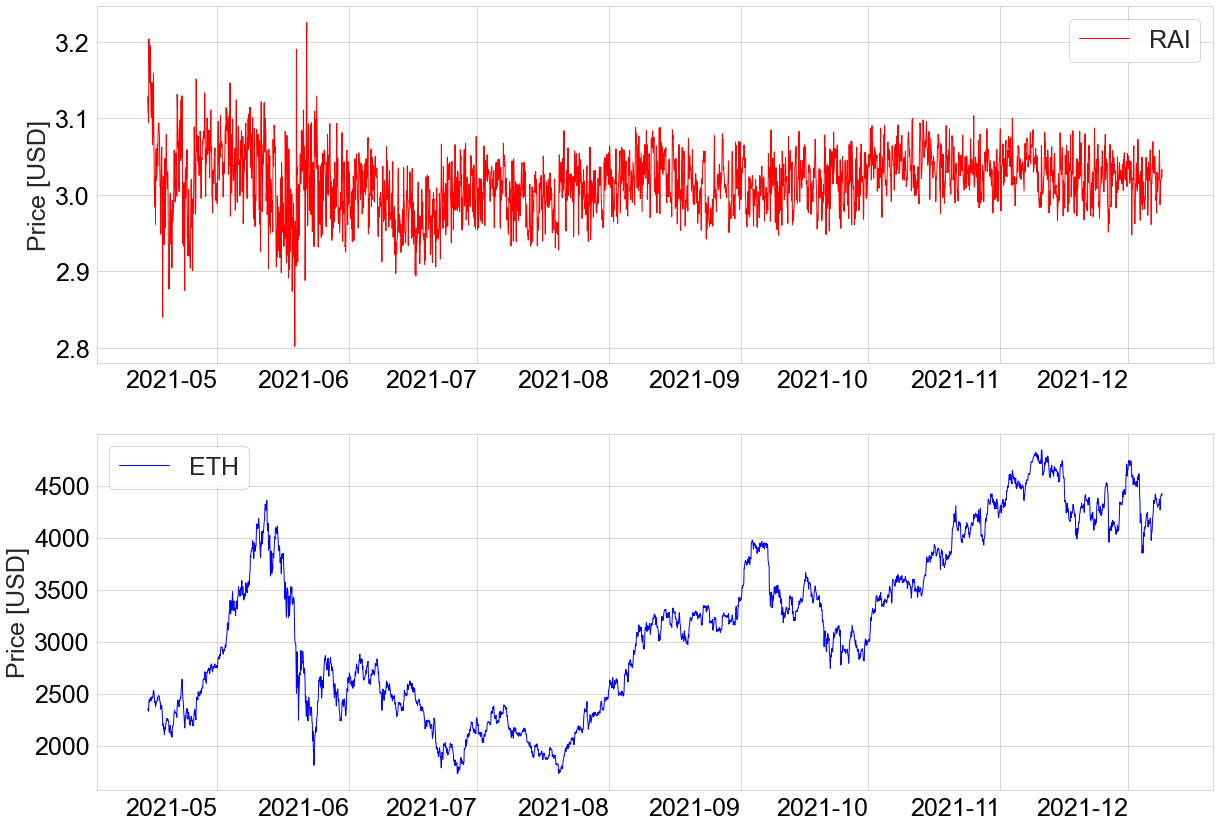

In [54]:
fig, axes = plt.subplots(2,1, figsize=(20, 16))

df_oracle_prices['raiusd_price'].plot(
    ax=axes[0],
    color='red',
    label='RAI',
    lw=1,
    rot=0
)

df_oracle_prices['ethusd_oracle_price'].plot(
    ax=axes[1],
    color='blue',
    label='ETH',
    lw=1,
    rot=0
)

for ax in axes:
    ax.set_ylabel("Price [USD]", fontsize=25)
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.legend(fontsize=25)

how did RAI perform around June 22, 2021? large crash event.

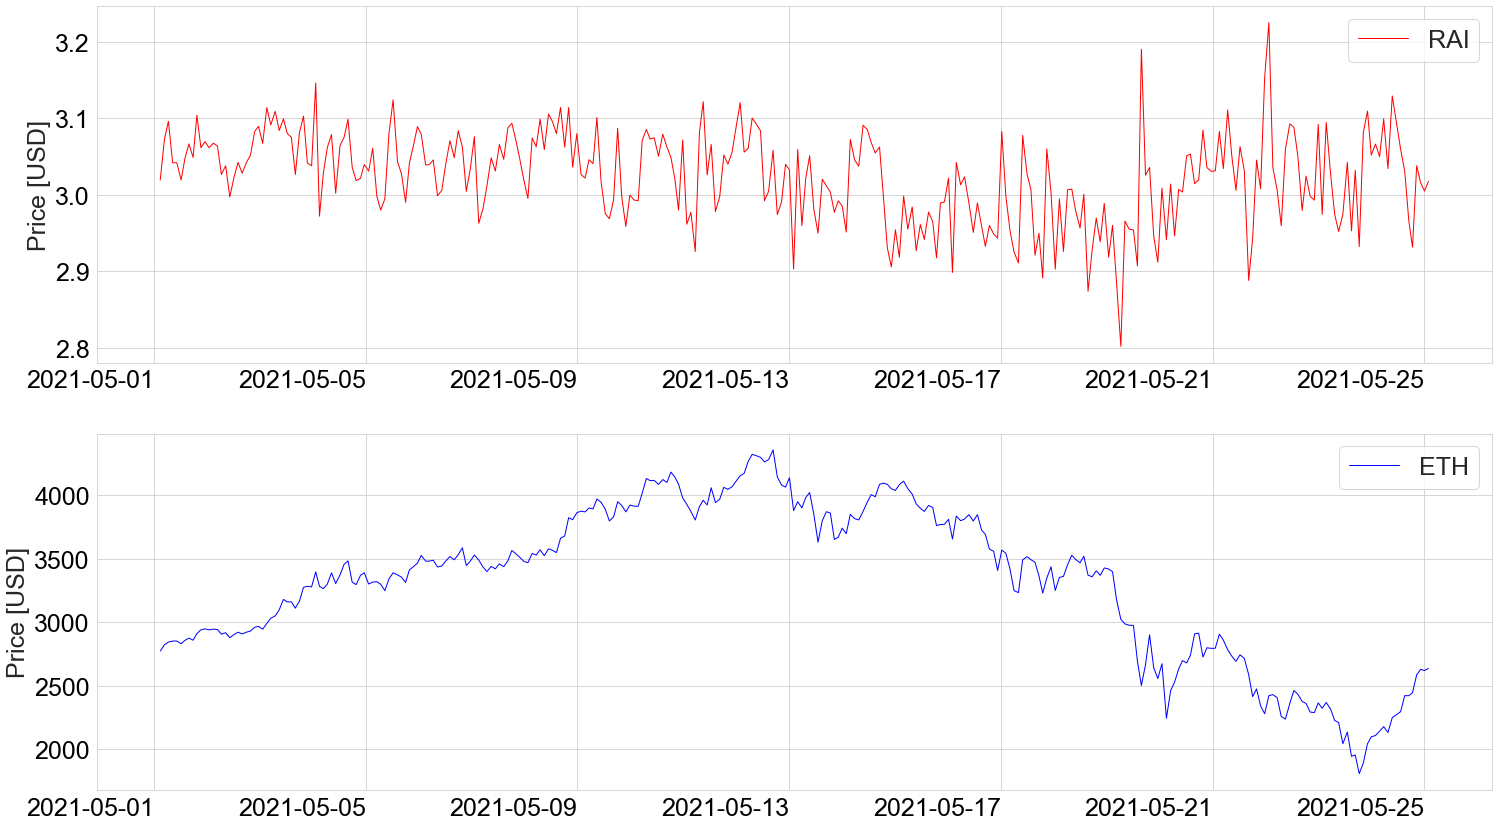

In [79]:
crash_start_block = get_block_for_timestamp(timestamp=int(pd.Timestamp('2021-05-01').timestamp()))
crash_end_block = get_block_for_timestamp(timestamp=int(pd.Timestamp('2021-05-25').timestamp()))
df_crash = df_oracle_prices.loc[
    (crash_start_block < df_oracle_prices.block_number) &
    (df_oracle_prices.block_number < crash_end_block)
]

fig, axes = plt.subplots(2,1, figsize=(25, 16))

df_crash['raiusd_price'].plot(
    ax=axes[0],
    color='red',
    label='RAI',
    lw=1,
    rot=0
)

df_crash['ethusd_oracle_price'].plot(
    ax=axes[1],
    color='blue',
    label='ETH',
    lw=1,
    rot=0
)

for ax in axes:
    ax.set_ylabel("Price [USD]", fontsize=25)
    ax.set_xlabel("")
    ax.tick_params(axis='both', which='major', labelsize=25, colors='black')
    ax.yaxis.get_major_formatter().set_scientific(False)
    ax.yaxis.get_major_formatter().set_useOffset(False)
    ax.legend(fontsize=25)